# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

In [3]:
# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [4]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [5]:
print('----------df.nunique()----------')
print(df.nunique()) 
print('----------df.describee()----------')
print(df.describe()) 
print('----------df.shape----------')
print(df.shape) 
print('----------df.dtypes----------')
print(df.dtypes) 
print('\n')
print('----------df_content.nunique()----------')
print(df_content.nunique())
print('----------df_content.describe()----------')
print(df_content.describe())
print('----------df_content.shape----------')
print(df_content.shape)
print('----------df_content.dtypes----------')
print(df_content.dtypes)

----------df.nunique()----------
article_id     714
title          714
email         5148
dtype: int64
----------df.describee()----------
         article_id
count  45993.000000
mean     908.846477
std      486.647866
min        0.000000
25%      460.000000
50%     1151.000000
75%     1336.000000
max     1444.000000
----------df.shape----------
(45993, 3)
----------df.dtypes----------
article_id    float64
title          object
email          object
dtype: object


----------df_content.nunique()----------
doc_body           1036
doc_description    1022
doc_full_name      1051
doc_status            1
article_id         1051
dtype: int64
----------df_content.describe()----------
        article_id
count  1056.000000
mean    523.913826
std     303.480641
min       0.000000
25%     260.750000
50%     523.500000
75%     786.250000
max    1050.000000
----------df_content.shape----------
(1056, 5)
----------df_content.dtypes----------
doc_body           object
doc_description    object
doc_fu

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

Notes

df:
- article_id = article id
- title = title name of article
- email - user who viewed the article

df_content:
- document details of article

Other findings:
* One user is able to interact with the same article multiple times

In [6]:
# User-interaction article count 
df[['email','article_id']].groupby(['email']).count().sort_values(by='article_id',ascending=False)

,article_id
email,
2b6c0f514c2f2b04ad3c4583407dccd0810469ee,364
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a,363
2f5c7feae533ce046f2cb16fb3a29fe00528ed66,170
a37adec71b667b297ed2440a9ff7dad427c7ac85,169
8510a5010a5d4c89f5b07baac6de80cd12cfaf93,160
...,...
1b520f0f65c0aee52d4235f92fb2de58fa966635,1
7a67e4a2902a20062e1f2a6835b6e099b34b4f6c,1
c4b7e639e91b1d18e5b9c000f0ad3354888fcdde,1


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [7]:
# identify duplicates for user-article pair
df[df[['article_id','email']].duplicated()]

,article_id,title,email
41,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
75,1429.0,use deep learning for image classification,3c2de1b0a92728aa53064a22ff7bd7319878ed95
95,1162.0,analyze energy consumption in buildings,d385b6c44711688ce2a33eb596495bf9243e1750
97,409.0,using github for project control in dsx,2b6c0f514c2f2b04ad3c4583407dccd0810469ee
99,1393.0,the nurse assignment problem,8dc8d7ec2356b1b106eb3d723f3c234e03ab3f1e
...,...,...,...
45972,588.0,tidyr 0.6.0,0f3f3b558c7a821ef18092c48ea924aff362ec53
45973,1398.0,total population by country,0f3f3b558c7a821ef18092c48ea924aff362ec53
45979,962.0,data visualization with r: scrum metrics,1b7a3f70a30b90837681376d48c1ae8832f9834b
45982,1324.0,ibm watson facebook posts for 2015,d21b998d7a4722310ceeaa3c6aaa181a36db2d73


In [8]:
# One email/user can view article multiple times
df[df['email'] == 'b96a4f2e92d8572034b1e9b28f9ac673765cd074']

,article_id,title,email
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
41,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
362,1330.0,insights from new york car accident reports,b96a4f2e92d8572034b1e9b28f9ac673765cd074
549,213.0,modeling energy usage in new york city,b96a4f2e92d8572034b1e9b28f9ac673765cd074
744,1172.0,"apache spark lab, part 3: machine learning",b96a4f2e92d8572034b1e9b28f9ac673765cd074
...,...,...,...
24352,1431.0,visualize car data with brunel,b96a4f2e92d8572034b1e9b28f9ac673765cd074
24392,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
24463,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
24529,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074


In [9]:
# Find and explore duplicate articles
df_content[df_content['article_id'].duplicated()]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [10]:
df_content.nunique()

doc_body           1036
doc_description    1022
doc_full_name      1051
doc_status            1
article_id         1051
dtype: int64

In [11]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset=['article_id'],keep='first')

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4
...,...,...,...,...,...
1051,PouchDB-find is a new API and syntax that allo...,PouchDB uses MapReduce as its default search m...,A look under the covers of PouchDB-find,Live,1046
1052,We compare discriminative and generative learn...,We compare discriminative and generative learn...,A comparison of logistic regression and naive ...,Live,1047
1053,"Essays about data, building products and boots...",In order to demystify some of the magic behind...,What I Learned Implementing a Classifier from ...,Live,1048
1054,NaN,Learn how to use IBM dashDB as data store for ...,Use dashDB with Spark,Live,1049


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [12]:
# Fill in the median and maximum number of user_article interactios below
median_val = df.groupby(['email']).count().median().article_id # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = df.groupby(['email']).count().max().article_id  # The maximum number of user-article interactions by any 1 user is ______. (number of articles)

In [13]:
unique_articles = df.nunique().article_id # The number of unique articles that have at least one interaction
total_articles = df_content.nunique().article_id # The number of unique articles on the IBM platform
unique_users = df.nunique().email # The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions

In [14]:
df_group_articleid = df.groupby(by=['article_id']).count().reset_index()
max_views = df_group_articleid.max().email # The most viewed article in the dataset was viewed how many times?
most_viewed_article_id = str(float(df_group_articleid[df_group_articleid['email'] == max_views].article_id)) # The most viewed article in the dataset as a string with one value following the decimal 

In [15]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


In [16]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [18]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    temp = df.groupby(['article_id','title']).count().sort_values(by='user_id',ascending=False).reset_index()
    temp.rename(columns={'user_id' : 'user_count'}, inplace=True)
    top_articles = list(temp.head(n).title)
    
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    temp = df.groupby(['article_id','title']).count().sort_values(by='user_id',ascending=False).reset_index()
    temp.rename(columns={'user_id' : 'user_count'}, inplace=True)
    top_articles = list(temp.head(n).article_id)
 
    return top_articles # Return the top article ids

In [19]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [20]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [24]:
df[['article_id','user_id']].groupby(['article_id']).count().unstack()

         article_id
user_id  0.0           14
         2.0           58
         4.0           13
         8.0           85
         9.0           10
                       ..
         1440.0        10
         1441.0         8
         1442.0         4
         1443.0        22
         1444.0         5
Length: 714, dtype: int64

In [25]:
df.user_id

0           1
1           2
2           3
3           4
4           5
         ... 
45988    5146
45989    5146
45990    5147
45991    5148
45992    5149
Name: user_id, Length: 45993, dtype: int64

In [21]:
df.sort_values(by=['user_id','article_id'])

,article_id,title,user_id
1710,43.0,deep learning with tensorflow course by big da...,1
1712,109.0,tensorflow quick tips,1
11083,151.0,jupyter notebook tutorial,1
20322,268.0,sector correlations shiny app,1
3839,310.0,time series prediction using recurrent neural ...,1
...,...,...,...
45985,1394.0,the nurse assignment problem data,5146
45984,1416.0,united states demographic measures: population...,5146
45990,233.0,bayesian nonparametric models – stats and bots,5147
45991,1160.0,analyze accident reports on amazon emr spark,5148


In [27]:
# temp1 = df[['article_id','user_id']].groupby(['article_id','user_id'])
temp1 = df.groupby(['article_id','user_id']).count().reset_index()
# .reset_index()
temp1.rename(columns={'title':'user_article_count'},inplace=True)
# temp1.sort_values(by=['user_id','article_id']).reset_index()
temp1
temp1[(temp1['article_id'] == 1436.0) & (temp1['user_id'] == 1)]
# temp1[(temp1['user_id'] == 1)].count()

,article_id,user_id,user_article_count
33195,1436.0,1,1


In [28]:
temp1.reset_index().nunique()

index                 33682
article_id              714
user_id                5149
user_article_count       26
dtype: int64

In [29]:
df

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5
...,...,...,...
45988,1324.0,ibm watson facebook posts for 2015,5146
45989,142.0,neural networks for beginners: popular types a...,5146
45990,233.0,bayesian nonparametric models – stats and bots,5147
45991,1160.0,analyze accident reports on amazon emr spark,5148


In [30]:
temp2 = df.merge(temp1, on=['article_id','user_id'],how='outer')
temp2

,article_id,title,user_id,user_article_count
0,1430.0,"using pixiedust for fast, flexible, and easier...",1,2
1,1430.0,"using pixiedust for fast, flexible, and easier...",1,2
2,1314.0,healthcare python streaming application demo,2,1
3,1429.0,use deep learning for image classification,3,25
4,1429.0,use deep learning for image classification,3,25
...,...,...,...,...
45988,1282.0,employed population by occupation and age,5146,1
45989,142.0,neural networks for beginners: popular types a...,5146,1
45990,233.0,bayesian nonparametric models – stats and bots,5147,1
45991,1160.0,analyze accident reports on amazon emr spark,5148,1


In [31]:
temp2[(temp2['article_id'] == 1436.0) & (temp2['user_id'] == 1)]

,article_id,title,user_id,user_article_count
23790,1436.0,welcome to pixiedust,1,1


In [32]:
# usr_itm = self.reviews[['user_id', 'movie_id', 'rating', 'timestamp']]
# self.user_item_df = usr_itm.groupby(['user_id','movie_id'])['rating'].max().unstack()
xx = temp1.groupby(['user_id','article_id'])['user_article_count'].max().unstack()
xx

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
xx.sum(axis=1)[1]

47.0

In [34]:
xx

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
xx2 = df.groupby(['user_id','article_id'])['title'].count().unstack()
xx2.count(axis=1)
# From rubric -> Create a matrix with users on the rows and articles on the columns. There should be a 1 if a user-article interacted with one another and a zero otherwise.
# Does not fully agree on this point as we are removing valuable data. ie, if we know user returns to the article, then it may be of interest to them or they need to read it multiple times
# For the sake of this project and its answers, will change it to 1 as below
xx2 = xx2.apply(lambda a : a/a)
xx2.replace(np.nan,0,inplace=True)
xx2.sum(axis=1)[1]
xx2

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    user_item = df.groupby(['user_id','article_id'])['title'].count().unstack()
    
    # update matrix to be of 1s and 0s only
    user_item = user_item.apply(lambda a : a/a)
    user_item.replace(np.nan,0,inplace=True)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [37]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


In [38]:
user_item.sum(axis=1)

user_id
1       36.0
2        6.0
3       40.0
4       26.0
5        3.0
        ... 
5145     5.0
5146     7.0
5147     1.0
5148     1.0
5149     1.0
Length: 5149, dtype: float64

In [39]:
user_item.iloc[0,:].sum()

36.0

In [40]:
user_item.iloc[0,:].shape

(714,)

In [41]:
user_item.iloc[:,:].shape

(5149, 714)

In [42]:
user_item.iloc[20,:].dot(np.transpose(user_item)).sort_values(ascending=False)[1:].reset_index()['user_id']

0       4785
1       3782
2         23
3       3764
4         98
        ... 
5143    2605
5144    2606
5145    2607
5146    2608
5147    5149
Name: user_id, Length: 5148, dtype: int64

In [43]:
user_id = 2
temp = user_item.iloc[user_id,:].dot(np.transpose(user_item)).drop(user_id)

# remove_userid = temp[temp['user_id'] != user_id]
# .rename
# remove_userid
# remove_userid.sort_values(ascending=False)



`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [252]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user

    # sort by similarity

    # create list of just the ids
   
    # remove the own user's id    
#     most_similar_users = list(user_item.loc[user_id,:].dot(np.transpose(user_item)).drop(user_id).sort_values(ascending=False).reset_index()['user_id'])
    most_similar_users = list(user_item.dot(np.transpose(user_item)).loc[user_id].drop(user_id).sort_values(ascending=False).reset_index()['user_id'])
    return most_similar_users # return a list of the users in order from most to least similar
        

In [262]:
user_id = 2


In [263]:
user_item.loc[user_id,:].dot(np.transpose(user_item)).drop(user_id).sort_values(ascending=False)

user_id
3764    5.0
3697    5.0
49      5.0
98      5.0
21      4.0
       ... 
1969    0.0
1968    0.0
1967    0.0
1966    0.0
5149    0.0
Name: 2, Length: 5148, dtype: float64

In [255]:
find_similar_users(1)

[3933,
 23,
 3782,
 203,
 4459,
 3870,
 131,
 46,
 4201,
 395,
 3697,
 49,
 5041,
 3622,
 242,
 322,
 3910,
 3764,
 2982,
 290,
 912,
 754,
 98,
 3540,
 4642,
 371,
 40,
 204,
 3651,
 135,
 5138,
 3637,
 268,
 273,
 1355,
 621,
 4932,
 3621,
 4785,
 3596,
 4134,
 21,
 256,
 3784,
 3775,
 52,
 64,
 3483,
 214,
 3141,
 619,
 1897,
 765,
 184,
 334,
 3136,
 3532,
 249,
 186,
 4755,
 4293,
 696,
 4778,
 4892,
 488,
 4038,
 2926,
 125,
 445,
 3684,
 4934,
 3024,
 4774,
 4484,
 5079,
 5013,
 60,
 5140,
 656,
 3632,
 38,
 665,
 54,
 4706,
 4206,
 3856,
 58,
 2790,
 10,
 288,
 4209,
 67,
 187,
 72,
 3740,
 193,
 3408,
 3354,
 195,
 4404,
 235,
 511,
 2975,
 3006,
 3485,
 3358,
 2981,
 3794,
 170,
 330,
 4883,
 244,
 2430,
 223,
 211,
 4471,
 3949,
 3353,
 4277,
 87,
 4595,
 733,
 362,
 28,
 3572,
 409,
 3693,
 4933,
 3197,
 3,
 3578,
 3879,
 4824,
 69,
 4225,
 379,
 295,
 3169,
 2161,
 807,
 8,
 4543,
 90,
 1040,
 111,
 261,
 113,
 263,
 591,
 3818,
 689,
 1059,
 324,
 4088,
 383,
 3741,
 3329

In [202]:
list(user_item.dot(np.transpose(user_item)).iloc[user_id].sort_values(ascending=False).reset_index()['user_id'])


[2,
 49,
 3764,
 98,
 3697,
 3782,
 38,
 21,
 23,
 5083,
 10,
 4785,
 2982,
 3354,
 3684,
 290,
 754,
 287,
 3057,
 3740,
 746,
 72,
 3622,
 3783,
 58,
 471,
 322,
 273,
 1063,
 3621,
 131,
 912,
 163,
 4778,
 170,
 173,
 3245,
 3238,
 135,
 3414,
 262,
 536,
 3540,
 111,
 3169,
 242,
 765,
 51,
 3082,
 3870,
 204,
 2908,
 4061,
 4145,
 4134,
 5138,
 2790,
 3910,
 35,
 4098,
 346,
 4209,
 1355,
 4,
 4230,
 2941,
 4901,
 214,
 203,
 4088,
 2270,
 4459,
 211,
 213,
 215,
 197,
 3483,
 3485,
 3500,
 4429,
 1033,
 230,
 3532,
 1372,
 409,
 4130,
 195,
 4904,
 958,
 4506,
 4900,
 403,
 938,
 4774,
 1409,
 4494,
 3376,
 3378,
 1405,
 186,
 187,
 383,
 188,
 235,
 4522,
 4487,
 663,
 3570,
 3548,
 2007,
 4876,
 3705,
 488,
 3727,
 4293,
 351,
 4201,
 4204,
 1198,
 3763,
 304,
 3775,
 343,
 3784,
 3801,
 3879,
 313,
 4255,
 3829,
 1240,
 1262,
 907,
 3691,
 3912,
 4934,
 4416,
 4932,
 333,
 246,
 1059,
 4404,
 249,
 3578,
 4933,
 3579,
 3933,
 3586,
 371,
 1552,
 3615,
 3968,
 3966,
 1338,
 36

In [203]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [2, 49, 3764, 98, 3697, 3782, 38, 21, 23, 5083]
The 5 most similar users to user 3933 are: [3934, 122, 3264, 126, 3172]
The 3 most similar users to user 46 are: [117, 2073, 131]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [49]:
df
# df_content

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5
...,...,...,...
45988,1324.0,ibm watson facebook posts for 2015,5146
45989,142.0,neural networks for beginners: popular types a...,5146
45990,233.0,bayesian nonparametric models – stats and bots,5147
45991,1160.0,analyze accident reports on amazon emr spark,5148


In [50]:
# df[df['article_id'].isin(list([1430.0,1310.0]))]['title']
# list(set(df[df['article_id'].isin(list([1430.0,1314.0,1429.0,1338.0]))]['title']))

(df[df['article_id'].isin(list([1430.0,1314.0,1429.0,1338.0]))]['title']).unique()

df[(df['article_id']).apply(lambda a : str(a)).isin((['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0']))]['title'].unique()


array(['healthcare python streaming application demo',
       'use xgboost, scikit-learn & ibm watson machine learning apis',
       'gosales transactions for naive bayes model',
       'use r dataframes & ibm watson natural language understanding',
       'build a python app on the streaming analytics service',
       'using deep learning to reconstruct high-resolution audio'],
      dtype=object)

In [51]:
len(df[df['user_id'] == 1]['article_id'].unique())

36

In [52]:
user_item.sum(axis=1)

user_id
1       36.0
2        6.0
3       40.0
4       26.0
5        3.0
        ... 
5145     5.0
5146     7.0
5147     1.0
5148     1.0
5149     1.0
Length: 5149, dtype: float64

In [53]:
user_item

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
df[df['user_id'] == 2]['article_id'].unique()

array([1314., 1305., 1024., 1176., 1422., 1427.])

In [55]:
list(user_item.loc[1][user_item.loc[1] == 1].reset_index()['article_id'])

[43.0,
 109.0,
 151.0,
 268.0,
 310.0,
 329.0,
 346.0,
 390.0,
 494.0,
 525.0,
 585.0,
 626.0,
 668.0,
 732.0,
 768.0,
 910.0,
 968.0,
 981.0,
 1052.0,
 1170.0,
 1183.0,
 1185.0,
 1232.0,
 1293.0,
 1305.0,
 1363.0,
 1368.0,
 1391.0,
 1400.0,
 1406.0,
 1427.0,
 1429.0,
 1430.0,
 1431.0,
 1436.0,
 1439.0]

In [59]:
# a,b = get_user_articles(1)


In [60]:
art_id_list = ['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0']
list(map(float, art_id_list))
df[(df['article_id']).isin(list(map(float, art_id_list)))]['title'].unique()


array(['healthcare python streaming application demo',
       'use xgboost, scikit-learn & ibm watson machine learning apis',
       'gosales transactions for naive bayes model',
       'use r dataframes & ibm watson natural language understanding',
       'build a python app on the streaming analytics service',
       'using deep learning to reconstruct high-resolution audio'],
      dtype=object)

In [61]:
df[(df['article_id']).isin([1024.0, '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])]['title'].unique()
# 

array(['using deep learning to reconstruct high-resolution audio'],
      dtype=object)

In [62]:
set(get_article_names([1024.0, '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])


NameError: name 'get_article_names' is not defined

In [63]:
# list(
list(user_item.loc[1][user_item.loc[1] == 1].reset_index()['article_id'].apply(str))
# .apply(lambda a : str(a))
# 
# 

['43.0',
 '109.0',
 '151.0',
 '268.0',
 '310.0',
 '329.0',
 '346.0',
 '390.0',
 '494.0',
 '525.0',
 '585.0',
 '626.0',
 '668.0',
 '732.0',
 '768.0',
 '910.0',
 '968.0',
 '981.0',
 '1052.0',
 '1170.0',
 '1183.0',
 '1185.0',
 '1232.0',
 '1293.0',
 '1305.0',
 '1363.0',
 '1368.0',
 '1391.0',
 '1400.0',
 '1406.0',
 '1427.0',
 '1429.0',
 '1430.0',
 '1431.0',
 '1436.0',
 '1439.0']

In [64]:
df[df['article_id'] == 43.0]

,article_id,title,user_id
271,43.0,deep learning with tensorflow course by big da...,24
329,43.0,deep learning with tensorflow course by big da...,28
459,43.0,deep learning with tensorflow course by big da...,186
515,43.0,deep learning with tensorflow course by big da...,11
659,43.0,deep learning with tensorflow course by big da...,207
...,...,...,...
45700,43.0,deep learning with tensorflow course by big da...,5138
45854,43.0,deep learning with tensorflow course by big da...,5140
45908,43.0,deep learning with tensorflow course by big da...,5140
45918,43.0,deep learning with tensorflow course by big da...,5140


In [65]:
df[df['article_id'] == 109.0]

,article_id,title,user_id
512,109.0,tensorflow quick tips,170
1712,109.0,tensorflow quick tips,1
2679,109.0,tensorflow quick tips,60
2692,109.0,tensorflow quick tips,184
2876,109.0,tensorflow quick tips,395
...,...,...,...
44756,109.0,tensorflow quick tips,5041
44943,109.0,tensorflow quick tips,5057
45746,109.0,tensorflow quick tips,5138
45892,109.0,tensorflow quick tips,5140


In [155]:
aa = list(user_item.loc[2][user_item.loc[2] == 1].reset_index()['article_id'].apply(str))
list(user_item.loc[2][user_item.loc[2] == 1].reset_index()['article_id'].apply(str))
get_article_names(aa)

array(['healthcare python streaming application demo',
       'use xgboost, scikit-learn & ibm watson machine learning apis',
       'gosales transactions for naive bayes model',
       'use r dataframes & ibm watson natural language understanding',
       'build a python app on the streaming analytics service',
       'using deep learning to reconstruct high-resolution audio'],
      dtype=object)

In [156]:
get_user_articles(1)

(['43.0',
  '109.0',
  '151.0',
  '268.0',
  '310.0',
  '329.0',
  '346.0',
  '390.0',
  '494.0',
  '525.0',
  '585.0',
  '626.0',
  '668.0',
  '732.0',
  '768.0',
  '910.0',
  '968.0',
  '981.0',
  '1052.0',
  '1170.0',
  '1183.0',
  '1185.0',
  '1232.0',
  '1293.0',
  '1305.0',
  '1363.0',
  '1368.0',
  '1391.0',
  '1400.0',
  '1406.0',
  '1427.0',
  '1429.0',
  '1430.0',
  '1431.0',
  '1436.0',
  '1439.0'],
 array(['using pixiedust for fast, flexible, and easier data analysis and experimentation',
        'use deep learning for image classification',
        'classify tumors with machine learning',
        'apache spark lab, part 1: basic concepts',
        'access db2 warehouse on cloud and db2 with python',
        'visualize car data with brunel',
        'use xgboost, scikit-learn & ibm watson machine learning apis',
        'putting a human face on machine learning',
        'gosales transactions for naive bayes model',
        'welcome to pixiedust',
        'uci ml repository

In [168]:
df[(df['article_id']).isin(list(map(float, ['1024.0', '1176.0', '1305.0'])))]
# ['using deep learning to reconstruct high-resolution audio', 
# 'build a python app on the streaming analytics service', 
# 'gosales transactions for naive bayes model']

,article_id,title,user_id
48,1305.0,gosales transactions for naive bayes model,35
141,1305.0,gosales transactions for naive bayes model,2
202,1305.0,gosales transactions for naive bayes model,35
251,1305.0,gosales transactions for naive bayes model,112
449,1305.0,gosales transactions for naive bayes model,112
...,...,...,...
45599,1024.0,using deep learning to reconstruct high-resolu...,5124
45688,1024.0,using deep learning to reconstruct high-resolu...,5135
45739,1305.0,gosales transactions for naive bayes model,5138
45809,1305.0,gosales transactions for naive bayes model,4293


In [169]:
df[df['user_id'] == 20]

,article_id,title,user_id
22,1320.0,housing (2015): united states demographic meas...,20
11988,844.0,use the cloudant-spark connector in python not...,20
16624,232.0,self-service data preparation with ibm data re...,20


In [170]:
get_user_articles(20)

([], array([], dtype=object))

In [172]:
list(user_item.loc[20][user_item.loc[1] == 20].reset_index()['article_id'].apply(str))

[]

In [178]:
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."


In [185]:
df[df['user_id'] == 20]['article_id'].apply(str).unique()

array(['1320.0', '844.0', '232.0'], dtype=object)

In [66]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    article_names = df[(df['article_id']).isin(list(map(float, article_ids)))]['title'].unique()
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
#     Code without thee need for user_item and using the original dtaframe instead
    article_ids = df[df['user_id'] == user_id]['article_id'].apply(str).unique()
#     Code using user_item -> Note too sure why we want to use user_item for this as may be unneeded
#     article_ids = list(user_item.loc[user_id][user_item.loc[user_id] == 1].reset_index()['article_id'].apply(str))
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    sim_users = find_similar_users(user_id)
    user_article_list_id, user_article_list_name = get_user_articles(user_id)
    recom_set = set()
    user_seen_set = set(user_article_list_id)
    for sim_user in sim_users:
        art_id, art_name = get_user_articles(sim_user)
        recom_set.update(set(art_id))
        recom_set -= user_seen_set
        if len(recom_set) >= m:
            break
    recs = list(recom_set)[:m]

    return recs # return your recommendations for this user_id    

In [67]:
user_article_list_id,user_article_list_name = get_user_articles(1)
user_article_list_id
set(user_article_list_id)

{'1052.0',
 '109.0',
 '1170.0',
 '1183.0',
 '1185.0',
 '1232.0',
 '1293.0',
 '1305.0',
 '1363.0',
 '1368.0',
 '1391.0',
 '1400.0',
 '1406.0',
 '1427.0',
 '1429.0',
 '1430.0',
 '1431.0',
 '1436.0',
 '1439.0',
 '151.0',
 '268.0',
 '310.0',
 '329.0',
 '346.0',
 '390.0',
 '43.0',
 '494.0',
 '525.0',
 '585.0',
 '626.0',
 '668.0',
 '732.0',
 '768.0',
 '910.0',
 '968.0',
 '981.0'}

In [68]:
test_set = set()
test_set.add('b')
test_set

{'b'}

In [69]:
recom_set.intersection(user_seen_set)

NameError: name 'recom_set' is not defined

In [121]:
test_user_id = 1
sim_users = find_similar_users(test_user_id)
sim_users
user_article_list_id,user_article_list_name = get_user_articles(test_user_id)
recom_set = set()
user_seen_set = set(user_article_list_id)
# counter = 0
# Sort users first based on their interaction with articles (ie highest interaction with all articles first)
for sim_user in sim_users:
    art_id, art_name = get_user_articles(sim_user)
    recom_set.update(set(art_id))
    recom_set -= user_seen_set
#     print(counter)
#     counter += 1
    if len(recom_set) >= 10:
        break
# list(recom_set)


# List of neighbors based on similarity
# user_item.iloc[user_id,:].dot(np.transpose(user_item)).drop(user_id).sort_values(ascending=False).reset_index()
# List of articles based on their interactions
# (df[['user_id','article_id']].groupby(['article_id']).count().sort_values(by='user_id',ascending=False).reset_index()['article_id'][:10])
# -----------
# output
# - neighbors_df [neightbor_id, similarity, interaction]

In [124]:
# user_item.sum(axis=1)

In [147]:
test_user_id = 1
a1 = user_item.iloc[test_user_id,:].dot(np.transpose(user_item)).drop(test_user_id).rename('sim_count').reset_index()
# List of neighbors based on similarity
# user_item.iloc[user_id,:].dot(np.transpose(user_item)).drop(user_id).sort_values(ascending=False).reset_index()
# List of articles based on their interactions
a2 = df[['user_id','article_id']].groupby(['user_id']).count().drop(test_user_id).rename(columns={'article_id':'num_interact'}).reset_index()
a3 = a1.merge(a2, on='user_id',how='inner')
a3.sort_values(by=['sim_count','num_interact'],ascending=False)
# -----------
# output
# - neighbors_df [neightbor_id, similarity, interaction]

,user_id,sim_count,num_interact
0,2,6.0,6
96,98,5.0,170
3762,3764,5.0,169
47,49,5.0,147
3695,3697,5.0,145
...,...,...,...
5139,5141,0.0,1
5142,5144,0.0,1
5145,5147,0.0,1
5146,5148,0.0,1


In [86]:
df[['user_id','article_id']].groupby(['article_id']).count().sort_values(by='user_id',ascending=False)

,user_id
article_id,
1429.0,937
1330.0,927
1431.0,671
1427.0,643
1364.0,627
...,...
1113.0,1
1119.0,1
984.0,1


In [72]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

array(['the nurse assignment problem',
       'use the cloudant-spark connector in python notebook',
       'model bike sharing data with spss',
       '1357    what i learned implementing a classifier from ...\nName: title, dtype: object',
       'country statistics: commercial bank prime lending rate',
       'a comparison of logistic regression and naive bayes ',
       "i'd rather predict basketball games than elections: elastic nba rankings",
       'how to choose a project to practice data science',
       'ensemble learning to improve machine learning results',
       'modern machine learning algorithms'], dtype=object)

In [73]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


In [74]:
user_item.iloc[user_id,:].dot(np.transpose(user_item))


user_id
1       2.0
2       6.0
3       1.0
4       3.0
5       0.0
       ... 
5145    1.0
5146    0.0
5147    0.0
5148    0.0
5149    0.0
Name: 2, Length: 5149, dtype: float64

In [75]:
# Find similar users abd their neighbor by length
# list(user_item.iloc[user_id,:].dot(np.transpose(user_item)).drop(user_id).sort_values(ascending=False).reset_index()['user_id'])
user_id = 1
xx = user_item.iloc[user_id].dot(np.transpose(user_item)).drop(user_id)
aaa = xx[xx > 0].sort_values(ascending=False)[:].reset_index()
# aaa[aaa['user_id'] != user_id]
aaa

,user_id,2
0,2,6.0
1,49,5.0
2,3697,5.0
3,98,5.0
4,3764,5.0
...,...,...
851,1319,1.0
852,1331,1.0
853,1334,1.0
854,1350,1.0


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [367]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    neighbors_df = user_item.dot(np.transpose(user_item)).loc[user_id].rename('similarity').reset_index()

    # number of user interactions on each article
    neighbors_df['num_interactions'] = df.groupby('user_id').count().reset_index()['title']

    # Sort and remove the first one which has highest similarity which is itself
    neighbors_df = neighbors_df.sort_values(by=['similarity','num_interactions'],ascending=False)[1:]
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    #     if user id does not exist -> get top articles and return
    if df['user_id'].isin([user_id]).sum() == 0:
        recs = list(map(str,get_top_article_ids(m)))
        rec_names = list(get_top_articles(m))
        return recs, rec_names
    
    sim_users = get_top_sorted_users(user_id)['user_id']
    user_article_list_id, user_article_list_name = get_user_articles(user_id)
    recom_set_id = set()
    recom_set_name = set()
    user_seen_set_id = set(user_article_list_id)
    user_seen_set_name = set(user_article_list_name)

    for sim_user in sim_users:
        art_id, art_name = get_user_articles(sim_user)
        recom_set_id.update(set(art_id))
        recom_set_id -= user_seen_set_id
        
        recom_set_name.update(set(art_name))
        recom_set_name -= user_seen_set_name
        if len(recom_set_id) >= m:
            break
    recs = list(recom_set_id)[:m]
    rec_names = list(recom_set_name)[:m]
    

        
    
    return recs, rec_names



In [368]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1407.0', '793.0', '1329.0', '1444.0', '1304.0', '1351.0', '1278.0', '1163.0', '1357.0', '336.0']

The top 10 recommendations for user 20 are the following article names:
['accelerate your workflow with dsx', 'apache spark lab, part 1: basic concepts', 'ibm watson facebook posts for 2015', 'probabilistic graphical models tutorial\u200a—\u200apart 1 – stats and bots', 'airbnb data for analytics: venice listings', 'analyze energy consumption in buildings', 'analyzing data by using the sparkling.data library features', 'uci: white wine quality', 'occupation (2015): united states demographic measures', 'neural networks for beginners: popular types and applications']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [321]:
top_articles = df[['user_id','article_id','title']].groupby(['article_id','title']).count().sort_values(by='user_id',ascending=False).reset_index()
[['article_id','title']][:10]
# .apply(str)

,article_id,title,user_id
0,1429.0,use deep learning for image classification,937
1,1330.0,insights from new york car accident reports,927
2,1431.0,visualize car data with brunel,671
3,1427.0,"use xgboost, scikit-learn & ibm watson machine...",643
4,1364.0,predicting churn with the spss random tree alg...,627
...,...,...,...
709,1113.0,airbnb data for analytics: new orleans reviews,1
710,1119.0,airbnb data for analytics: oakland reviews,1
711,984.0,the data processing inequality,1
712,1127.0,airbnb data for analytics: san diego listings,1


In [383]:
get_top_sorted_users(1).sort_values(by='similarity',ascending=False)['user_id'].iloc[0]

3933

In [419]:
### Tests with a dictionary of results
user1_most_sim = get_top_sorted_users(1).iloc[0].user_id # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).iloc[9].user_id # Find the 10th most similar user to user 131

In [420]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [421]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
user_recs, user_recs_name = user_user_recs_part2(new_user,10)
new_user_recs = user_recs # Your recommendations here

In [422]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [423]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [424]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,1017.0,1018.0,102.0,1024.0,1025.0,1028.0,103.0,1030.0,1035.0,1038.0,1042.0,1043.0,1044.0,1047.0,1048.0,1050.0,1051.0,1052.0,1053.0,1054.0,1055.0,1056.0,1057.0,1058.0,1059.0,1060.0,1061.0,1062.0,1063.0,1064.0,1065.0,1066.0,1067.0,1068.0,1069.0,107.0,1070.0,1071.0,1072.0,1073.0,...,898.0,9.0,903.0,905.0,906.0,910.0,911.0,919.0,92.0,926.0,928.0,930.0,932.0,933.0,935.0,936.0,939.0,940.0,941.0,943.0,947.0,948.0,949.0,951.0,952.0,955.0,957.0,958.0,959.0,96.0,961.0,962.0,965.0,967.0,968.0,969.0,972.0,973.0,974.0,975.0,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [427]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

**Provide your response here.**

From our lesson, when we run it fails because it does not support matrices with any missing values.
Here, it works since there are no null and all is treates as 0s or 1s.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

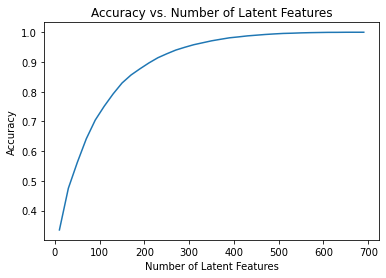

In [431]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

In [453]:
create_user_item_matrix(df_test)


article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,20.0,25.0,26.0,28.0,29.0,30.0,32.0,33.0,34.0,36.0,39.0,40.0,43.0,48.0,50.0,51.0,53.0,54.0,57.0,58.0,59.0,60.0,62.0,64.0,65.0,68.0,74.0,76.0,77.0,78.0,80.0,81.0,82.0,87.0,89.0,92.0,96.0,98.0,100.0,101.0,...,1377.0,1378.0,1386.0,1387.0,1391.0,1393.0,1394.0,1395.0,1396.0,1397.0,1398.0,1400.0,1401.0,1402.0,1403.0,1404.0,1405.0,1406.0,1407.0,1408.0,1409.0,1410.0,1411.0,1412.0,1414.0,1415.0,1416.0,1418.0,1419.0,1420.0,1422.0,1423.0,1424.0,1425.0,1426.0,1427.0,1428.0,1429.0,1430.0,1431.0,1432.0,1433.0,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1443.0
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3024,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5147,0.0

In [459]:
list(create_user_item_matrix(df_test).reset_index()['user_id'])

[2917,
 3024,
 3093,
 3193,
 3527,
 3532,
 3684,
 3740,
 3777,
 3801,
 3968,
 3989,
 3990,
 3998,
 4002,
 4204,
 4231,
 4274,
 4293,
 4487,
 4488,
 4489,
 4490,
 4491,
 4492,
 4493,
 4494,
 4495,
 4496,
 4497,
 4498,
 4499,
 4500,
 4501,
 4502,
 4503,
 4504,
 4505,
 4506,
 4507,
 4508,
 4509,
 4510,
 4511,
 4512,
 4513,
 4514,
 4515,
 4516,
 4517,
 4518,
 4519,
 4520,
 4521,
 4522,
 4523,
 4524,
 4525,
 4526,
 4527,
 4528,
 4529,
 4530,
 4531,
 4532,
 4533,
 4534,
 4535,
 4536,
 4537,
 4538,
 4539,
 4540,
 4541,
 4542,
 4543,
 4544,
 4545,
 4546,
 4547,
 4548,
 4549,
 4550,
 4551,
 4552,
 4553,
 4554,
 4555,
 4556,
 4557,
 4558,
 4559,
 4560,
 4561,
 4562,
 4563,
 4564,
 4565,
 4566,
 4567,
 4568,
 4569,
 4570,
 4571,
 4572,
 4573,
 4574,
 4575,
 4576,
 4577,
 4578,
 4579,
 4580,
 4581,
 4582,
 4583,
 4584,
 4585,
 4586,
 4587,
 4588,
 4589,
 4590,
 4591,
 4592,
 4593,
 4594,
 4595,
 4596,
 4597,
 4598,
 4599,
 4600,
 4601,
 4602,
 4603,
 4604,
 4605,
 4606,
 4607,
 4608,
 4609,
 4610,

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [635]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    # Test user ids
    test_idx = list(create_user_item_matrix(df_test).reset_index()['user_id'])
    # Test article ids
    test_arts = list(create_user_item_matrix(df_test).columns)
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [581]:
# Common items in train and test user_item that can be predicted only common ones
common_item_df_train = user_item_train[user_item_train.index.isin(user_item_test.index)]
common_item_df_test = user_item_test[user_item_test.index.isin(user_item_train.index)]
common_item_df_train
# This is the train data that we can use

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,20.0,25.0,26.0,28.0,29.0,30.0,32.0,33.0,34.0,36.0,39.0,40.0,43.0,48.0,50.0,51.0,53.0,54.0,57.0,58.0,59.0,60.0,62.0,64.0,65.0,68.0,74.0,76.0,77.0,78.0,80.0,81.0,82.0,87.0,89.0,92.0,96.0,98.0,100.0,101.0,...,1390.0,1391.0,1393.0,1394.0,1395.0,1396.0,1397.0,1398.0,1400.0,1401.0,1402.0,1403.0,1404.0,1405.0,1406.0,1407.0,1408.0,1409.0,1410.0,1411.0,1412.0,1414.0,1415.0,1416.0,1418.0,1419.0,1420.0,1421.0,1422.0,1423.0,1424.0,1425.0,1426.0,1427.0,1428.0,1429.0,1430.0,1431.0,1432.0,1433.0,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3532,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3684,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3777,0.

In [582]:
common_item_df_train

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,20.0,25.0,26.0,28.0,29.0,30.0,32.0,33.0,34.0,36.0,39.0,40.0,43.0,48.0,50.0,51.0,53.0,54.0,57.0,58.0,59.0,60.0,62.0,64.0,65.0,68.0,74.0,76.0,77.0,78.0,80.0,81.0,82.0,87.0,89.0,92.0,96.0,98.0,100.0,101.0,...,1390.0,1391.0,1393.0,1394.0,1395.0,1396.0,1397.0,1398.0,1400.0,1401.0,1402.0,1403.0,1404.0,1405.0,1406.0,1407.0,1408.0,1409.0,1410.0,1411.0,1412.0,1414.0,1415.0,1416.0,1418.0,1419.0,1420.0,1421.0,1422.0,1423.0,1424.0,1425.0,1426.0,1427.0,1428.0,1429.0,1430.0,1431.0,1432.0,1433.0,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3532,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3684,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3777,0.

In [583]:
# Number of users we can make predictions for in test set
common_item_df_train.shape[0]

20

In [586]:
# Number of predictions we cannot make in test set (subtracting what we can with total)
user_item_test.shape[0] - common_item_df_train.shape[0]

662

In [587]:
# Number of articles we can make prediction for in test set
# Can make prediction for all test articles
user_item_test.shape[1]

574

In [588]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, # letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, # letter here,
    'How many movies can we make predictions for in the test set?': b, # letter here,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d # letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [667]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

In [668]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

In [669]:
u_train.shape,s_train.shape,vt_train.shape

((4487, 4487), (714,), (714, 714))

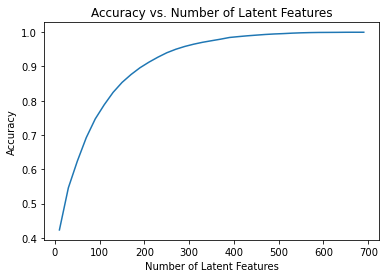

In [648]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_train, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

In [670]:
# Here shows that if we have a lot of latent features, ie around 600-700, 
# then we are getting a high accuracy
# Prediction can then be done with high latent feature numbers

In [656]:
k

690

In [674]:
# This gives dataframe of user_id x article_id prediction for all users
# To get the prediction of the 20 users, we just need to capture them out
# estimate used at 690 latent features
user_item_est_df = pd.DataFrame(user_item_est)
user_item_est_df.columns = common_item_df_train.columns
user_item_est_df.index += 1
user_item_est_df

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,20.0,25.0,26.0,28.0,29.0,30.0,32.0,33.0,34.0,36.0,39.0,40.0,43.0,48.0,50.0,51.0,53.0,54.0,57.0,58.0,59.0,60.0,62.0,64.0,65.0,68.0,74.0,76.0,77.0,78.0,80.0,81.0,82.0,87.0,89.0,92.0,96.0,98.0,100.0,101.0,...,1390.0,1391.0,1393.0,1394.0,1395.0,1396.0,1397.0,1398.0,1400.0,1401.0,1402.0,1403.0,1404.0,1405.0,1406.0,1407.0,1408.0,1409.0,1410.0,1411.0,1412.0,1414.0,1415.0,1416.0,1418.0,1419.0,1420.0,1421.0,1422.0,1423.0,1424.0,1425.0,1426.0,1427.0,1428.0,1429.0,1430.0,1431.0,1432.0,1433.0,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
1,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,1.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,...,-0.0,1.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,1.0,0.0,0.0,-0.0,0.0,0.0,1.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,1.0,0.0,1.0,1.0,1.0,0.0,-0.0,0.0,0.0,1.0,0.0,1.0,-0.0,0.0,0.0,0.0,-0.0
2,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,...,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,1.0,0.0,-0.0,-0.0,-0.0,1.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0
3,-0.0,0.0,0.0,-0.0,-0.0,1.0,-0.0,-0.0,0.0,-0.0,1.0,-0.0,0.0,0.0,1.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,1.0,-0.0,1.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,1.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,1.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,1.0,0.0,1.0,1.0,-0.0,0.0,0.0,1.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,1.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,1.0,0.0,-0.0,-0.0,1.0,-0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0
5,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,...,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4483,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,1.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0
4484,-0.0,1.0,0.0,1.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,1.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,1.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0

In [675]:
# Prediction based on k latent features using the matrix that predicts all users together
user_item_est_df[user_item_est_df.index.isin(common_item_df_train.index)]


article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,20.0,25.0,26.0,28.0,29.0,30.0,32.0,33.0,34.0,36.0,39.0,40.0,43.0,48.0,50.0,51.0,53.0,54.0,57.0,58.0,59.0,60.0,62.0,64.0,65.0,68.0,74.0,76.0,77.0,78.0,80.0,81.0,82.0,87.0,89.0,92.0,96.0,98.0,100.0,101.0,...,1390.0,1391.0,1393.0,1394.0,1395.0,1396.0,1397.0,1398.0,1400.0,1401.0,1402.0,1403.0,1404.0,1405.0,1406.0,1407.0,1408.0,1409.0,1410.0,1411.0,1412.0,1414.0,1415.0,1416.0,1418.0,1419.0,1420.0,1421.0,1422.0,1423.0,1424.0,1425.0,1426.0,1427.0,1428.0,1429.0,1430.0,1431.0,1432.0,1433.0,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
2917,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,1.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0
3024,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,1.0,0.0,1.0,0.0,0.0,-0.0,-0.0,1.0,-0.0,-0.0,0.0,-0.0,1.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,1.0,0.0,1.0,0.0,-0.0,0.0,-0.0,1.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0
3093,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,1.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,...,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
3193,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,1.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0
3527,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0
3532,0.0,-0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,1.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,...,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,1.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.0,0.0,0.0,0.0,1.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,1.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0
3684,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,1.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,...,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,1.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,1.0,-0.0,0.0,-0.0,-0.0,1.0,0.0,1.0,0.0,-0.0,-0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0
3740,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,1.0,0.0,-0.0,0.0,1.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,

In [634]:
# 1. Predict just 20 users from common_item_train with train data
# 2. Test this results with common_item_test results
# 3. find fidd and error to show performance

In [ ]:
# use the normal user matrix, the break it out, then when predict, tak just 20 people which has overlap

In [613]:
# Predict based on the 20 overlapping users
# NOTE -> decompose first to see different latent feature count usage
# Either that, or just show in the plot for perforamnce? hmm
pred_20_articles = common_item_df_train.dot(vt_train)
pred_20_articles.columns = common_item_df_train.columns
pred_20_articles


article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,20.0,25.0,26.0,28.0,29.0,30.0,32.0,33.0,34.0,36.0,39.0,40.0,43.0,48.0,50.0,51.0,53.0,54.0,57.0,58.0,59.0,60.0,62.0,64.0,65.0,68.0,74.0,76.0,77.0,78.0,80.0,81.0,82.0,87.0,89.0,92.0,96.0,98.0,100.0,101.0,...,1390.0,1391.0,1393.0,1394.0,1395.0,1396.0,1397.0,1398.0,1400.0,1401.0,1402.0,1403.0,1404.0,1405.0,1406.0,1407.0,1408.0,1409.0,1410.0,1411.0,1412.0,1414.0,1415.0,1416.0,1418.0,1419.0,1420.0,1421.0,1422.0,1423.0,1424.0,1425.0,1426.0,1427.0,1428.0,1429.0,1430.0,1431.0,1432.0,1433.0,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2917,0.022385,-0.003368,0.176127,0.086793,-0.047237,0.044176,0.112975,-0.033072,0.022430,-0.037768,0.402596,0.179511,0.105593,0.088399,0.031618,-0.035475,0.070683,-0.096548,0.134122,0.164727,-0.200256,-0.003787,-0.231756,0.155310,0.183658,-0.010408,0.212335,0.062852,0.055149,-0.045003,-0.158224,0.065806,0.088941,0.141113,0.012745,-0.033062,0.060578,0.015010,-0.077041,0.146804,-0.007703,0.011254,0.028531,0.071074,0.100018,0.109033,0.010514,-0.249755,-0.006628,-0.142395,...,0.438829,-0.184943,0.030040,0.212588,0.008544,0.160037,0.067556,0.092348,0.243903,0.018947,0.029823,-0.033339,-0.067861,-0.060704,0.195002,-0.201330,-0.022538,-0.043443,-0.011189,-0.003760,-0.111445,0.200246,-0.032003,0.068251,-0.083315,0.062541,-0.047664,0.003222,-0.111445,-0.112254,-0.075113,-0.176300,0.106576,0.031470,-0.100704,0.147172,-0.039307,0.154207,-0.211103,-0.100880,0.080352,-0.135078,-0.000114,-0.155696,0.072605,0.254914,-0.039808,-0.005846,-0.001143,-0.027681
3024,0.334438,0.162281,-0.038432,0.215291,-0.275588,0.308386,-0.249859,-0.225797,0.053839,-0.016429,0.255941,0.208980,-0.130864,-0.086279,0.073292,0.091648,-0.024569,0.034858,0.004052,-0.045768,-0.016171,-0.114223,-0.292393,-0.131192,0.056057,0.267873,0.183828,0.144467,-0.546481,0.183936,-0.164383,-0.029880,0.227739,-0.096797,-0.138088,0.090319,0.341326,0.151868,-0.292269,0.007486,0.087851,0.222871,0.007439,-0.111423,-0.047107,-0.030151,-0.238920,-0.140591,-0.047972,-0.123385,...,-0.081141,0.105910,0.082031,-0.146207,-0.152173,-0.468439,0.145049,0.446620,0.291825,0.140286,0.123362,-0.107090,-0.265481,0.052885,-0.152105,0.043556,-0.270821,0.043152,-0.075150,0.074311,-0.233017,0.114008,0.155599,0.124910,0.033540,0.108392,0.254559,0.022772,0.216000,-0.263755,-0.239200,0.074217,0.068124,0.377211,0.008801,0.094589,0.217195,0.035884,0.007908,-0.336138,-0.057246,-0.243667,0.149068,-0.168837,0.184499,0.065300,-0.299314,-0.097767,-0.107705,-0.151498
3093,-0.081329,0.156984,0.093337,-0.033640,0.048577,-0.220379,0.098638,0.035634,0.085836,0.064486,0.277666,0.090667,-0.295648,-0.084309,-0.154178,0.083887,-0.019597,0.006118,0.592152,-0.148163,-0.108473,0.267568,-0.121281,-0.007565,0.161961,0.321083,-0.172594,0.160205,-0.188609,-0.024853,-0.009975,0.007620,0.222299,-0.180876,0.043934,-0.046190,-0.019724,-0.154758,0.002374,-0.253576,-0.249031,-0.086711,-0.010274,0.074296,0.288508,-0.062319,-0.105296,-0.076014,-0.003033,-0.038348,...,0.035150,0.097017,-0.008033,-0.093468,0.083205,-0.257968,0.051345,0.374194,0.203055,-0.015864,0.051627,-0.055880,0.092330,0.004754,-0.181535,-0.098291,-0.092088,0.386870,-0.088602,-0.005425,0.012742,0.079264,0.080474,0.054669,-0.146658,-0.028175,-0.239435,-0.035863,0.085716,0.130192,0.073408,-0.187525,-0.113310,0.225196,0.152292,0.273172,0.060756,-0.137841,0.044423,-0.084922,-0.130878,0.076679,-0.017314,-0.076543,0.251787,-0.075484,-0.076460,-0.009519,-0.049530,-0.093134
3193,0.006104,0.000679,0.002901,0.001466,0.010786,-0.001433,-0.001412,-0.002710,0.004672,0.006235,-0.000170,-0.000789,0.004135,-0.004304,-0.000378,0.000026,0.002061,-0.003079,0.002237,-0.000400,-0.000512,0.000922,-0.001680,0.000626,-0.001242,-0.000765,-0.001738,-0.003876,-0.004084,-0.002824,0.017183,0.002235,-0.000855,-0.000302,0.005621,0.002310,-0.000635,0.004915,0.001341,0.000639,-0.008211,-0.004789,0

In [614]:
# sum diff between the common test items and the predicted articles
np.sum((pred_20_articles-common_item_df_test)**2)

article_id
0.0       0.329635
2.0       0.205480
4.0       0.210544
8.0       0.290698
9.0       0.403605
            ...   
1440.0    0.424879
1441.0    0.631841
1442.0    0.000000
1443.0    0.213732
1444.0    0.000000
Length: 714, dtype: float64

In [618]:
# Turning the prediction before to 1s and 0s based on their positivity and negativity
pred_20_articles_xx = pred_20_articles.copy()
pred_20_articles_xx[pred_20_articles_xx <= 0] = 0
pred_20_articles_xx = pred_20_articles_xx.apply(lambda a : a/a)
pred_20_articles_xx = pred_20_articles_xx.fillna(0)
pred_20_articles_xx

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,20.0,25.0,26.0,28.0,29.0,30.0,32.0,33.0,34.0,36.0,39.0,40.0,43.0,48.0,50.0,51.0,53.0,54.0,57.0,58.0,59.0,60.0,62.0,64.0,65.0,68.0,74.0,76.0,77.0,78.0,80.0,81.0,82.0,87.0,89.0,92.0,96.0,98.0,100.0,101.0,...,1390.0,1391.0,1393.0,1394.0,1395.0,1396.0,1397.0,1398.0,1400.0,1401.0,1402.0,1403.0,1404.0,1405.0,1406.0,1407.0,1408.0,1409.0,1410.0,1411.0,1412.0,1414.0,1415.0,1416.0,1418.0,1419.0,1420.0,1421.0,1422.0,1423.0,1424.0,1425.0,1426.0,1427.0,1428.0,1429.0,1430.0,1431.0,1432.0,1433.0,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2917,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3024,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3093,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3193,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
3527,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
3532,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3684,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
3740,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3777,0.

In [632]:
error1 = np.sum((pred_20_articles-common_item_df_test)**2)
error1.sort_values().rename('error_value').reset_index()['error_value']
error2 = np.sum((pred_20_articles_xx-common_item_df_test)**2)
error2.sort_values().rename('error_value').reset_index()['error_value']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
709    15.0
710    15.0
711    16.0
712    18.0
713    18.0
Name: error_value, Length: 714, dtype: float64

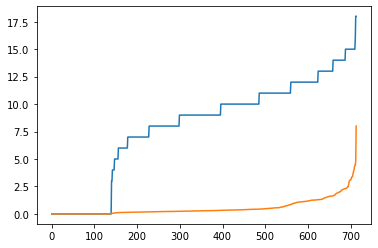

In [633]:
plt.plot(error2.sort_values().rename('error_value').reset_index()['error_value']);
plt.plot(error1.sort_values().rename('error_value').reset_index()['error_value']);

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**

Note that here, we are using SVD only and not including FunkSVD. This is because we note that there is a rating, or article read for all and if there is none, we turn them to "0". Which invalidates the null in this case.

What we could have also done is to note the users who have not read it as "null" before but in that case, we should note the number of interactions for each article as well.

The other point that this works is becasue we also assumes that if it is a new user, then we are just going to recommend them the top articles to solve the cold start problem in this case.

From our predictions, we have seen that it is working well but the main limitation is that we are only able to predict and truely test for just 20 users because those exist in both the training and test dataset.
What we could do is also validate the user based on time whether a user rate before and after to predict whether they are going to read an article by themselves or not and like it or not.

Another indicator we can potentially use is the number of interactions a specific user have to a specific article. This could either mean that they are revisiting because they enjoy the article as well.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])